# Colima Inversion Examples



In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df)

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF00-04a,1499,1506,625.8,60,19,31,18,11,6,2,1,1,1,"2,124.86"
18,VF00-06a3,1957,1997,417.2,40,7,30,25,17,11,5,1,1,1,"2,796.04"
17,VF00-05a3,1787,2173,500.64,48,10,30,24,16,9,3,1,1,1,"2,813.41"
37,VF06-03/5-09,-770,3082,594.51,57,11,25,25,19,11,4,1,1,1,"3,176.73"
31,VF05-08a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,1,1,"3,568.48"
36,VF05-18a3,-637,4876,166.88,16,3,21,25,22,16,7,2,1,1,"4,917.43"
35,VF05-17a,-1268,5048,125.16,12,10,14,17,20,17,10,4,2,2,"5,204.82"
34,VF05-16a3,-2101,5517,93.87,9,4,15,19,19,19,12,4,3,3,"5,903.52"
33,VF05-14a3,-2250,5771,62.58,6,0,9,13,19,21,14,7,5,6,"6,194.11"
32,VF05-13a,-2272,5925,62.58,6,4,9,17,19,17,11,8,6,4,"6,345.68"


## Preprossessing Steps

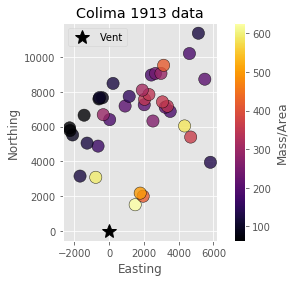

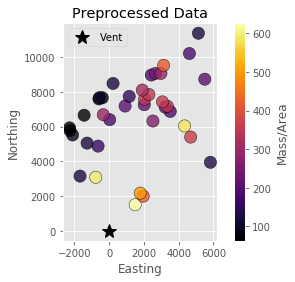

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.73,23.1529,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.0103587,"2,124.86",1.17087
18,1957,1997,0,691.154,21.3541,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.0128943,"2,796.04",1.65665
17,1787,2173,0,709.841,21.2137,24.71,22.4801,16.6062,9.88889,3.93999,0.980849,0.16722,0.013114,"2,813.41",1.41787
37,-770,3082,0,301.066,13.8022,19.2173,22.1297,20.4626,14.7247,7.12663,2.10569,0.398324,0.0329064,"3,176.73",0.50641
31,-1673,3152,0,149.68,9.51561,14.8613,20.3208,22.2637,18.4942,10.3172,3.45994,0.706562,0.0606982,"3,568.48",1.19591


In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,"1,394.46",17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,2.84769e-05,"2,124.86",2.22828
18,1957,1997,2500,"1,216.15",14.016,22.3619,24.864,20.2838,12.7356,4.93885,0.76913,0.0307052,6.30498e-05,"2,796.04",2.91503
17,1787,2173,2500,"1,251",13.877,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.0313104,6.44789e-05,"2,813.41",2.4988
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.0410962,9.09858e-05,"3,176.73",0.60453
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.07907,0.054478,0.000131905,"3,568.48",1.07303


In [6]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,"1,024","[-5,-4)",-5,0.0683375,-4
1,-3.5,"1,024","[-4,-3)",-4,0.109203,-3
2,-2.5,"1,024","[-3,-2)",-3,0.146694,-2
3,-1.5,"1,024","[-2,-1)",-2,0.16565,-1
4,-0.5,"1,024","[-1,0)",-1,0.157243,0
5,0.5,"1,233.5","[0,1)",0,0.125474,1
6,1.5,"1,443","[1,2)",1,0.0841661,2
7,2.5,"1,652.5","[2,3)",2,0.0474595,3
8,3.5,"1,862","[3,4)",3,0.0224962,4


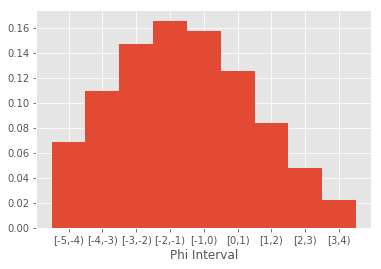

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.03125 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.07812 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,17.0237,24.0587,24.7461,19.0106,10.9865,3.68062,0.476505,0.0172657,3.63504e-05,"1,316.8","2,124.86",2.10419
1,1997,1957,13.849,22.1879,24.803,20.3647,12.8847,5.06294,0.813217,0.0344694,8.0275e-05,"1,148.99","2,796.04",2.75405
2,2173,1787,13.8004,22.2099,24.865,20.38,12.8556,5.04311,0.811521,0.0345019,8.06424e-05,"1,166.99","2,813.41",2.33099
3,3082,-770,15.5611,23.6747,24.9019,19.0596,11.4484,4.52251,0.794749,0.0368917,9.33995e-05,300.905,"3,176.73",0.506139
4,3152,-1673,16.2556,24.3211,24.9428,18.4296,10.7682,4.36764,0.869463,0.0453801,0.000126158,111.015,"3,568.48",0.886983


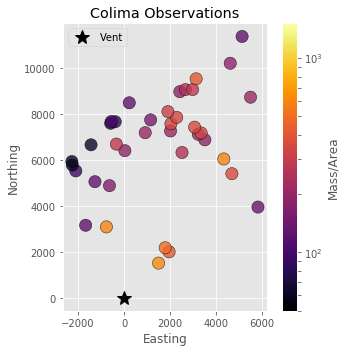

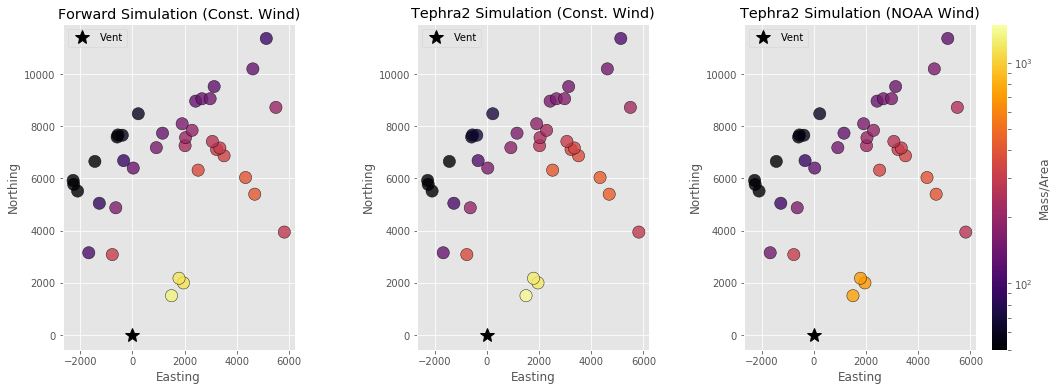

In [9]:

fig, ax = plt.subplots(1, 1, figsize=(5,5))

vis.plot_sample(obs_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Colima Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])
plt.show()




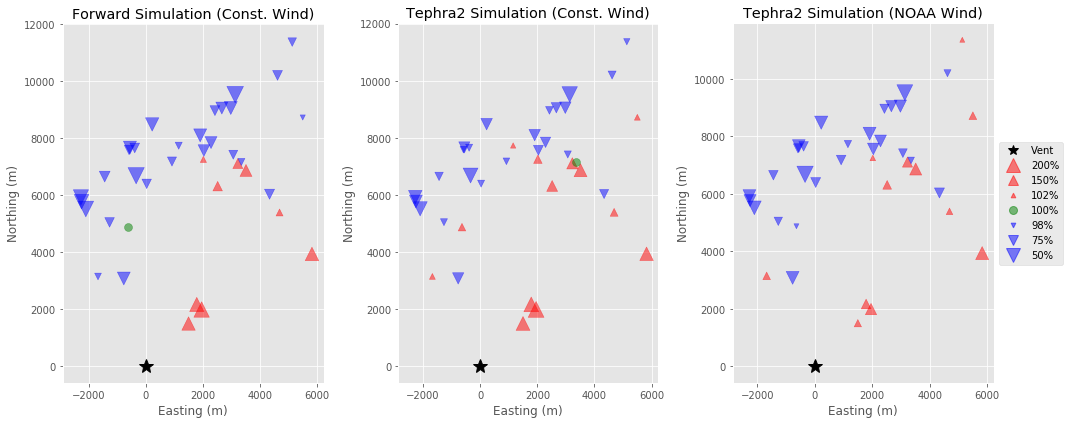

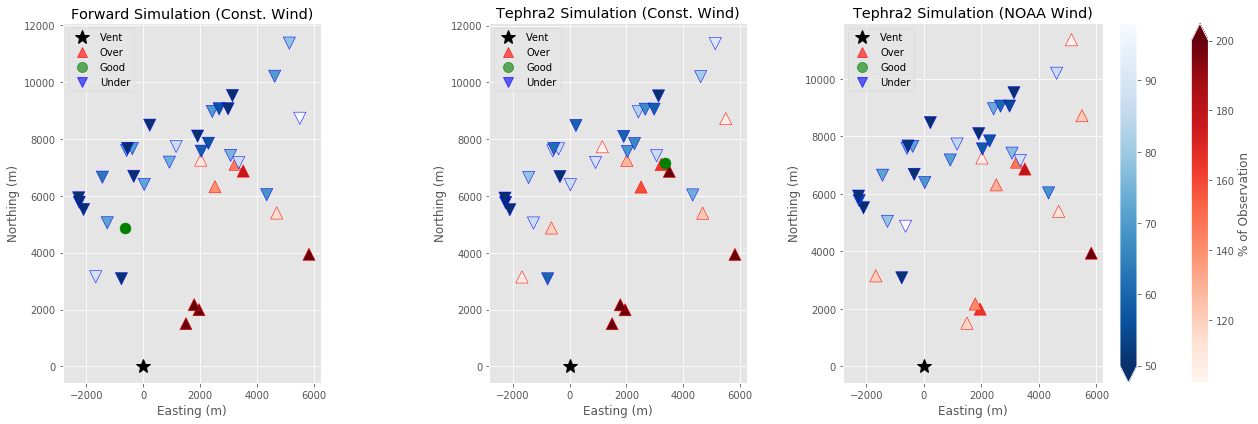

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(
        15,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)",  show_legend=False, 
            plot_type = "size", ax=axs[0])
vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (Const. Wind)", show_legend=False, 
             plot_type = "size", ax=axs[1])
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (NOAA Wind)",  show_legend=True, 
             plot_type = "size", ax=axs[2])


plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "cmap", ax=axs[0], show_cbar = False)
vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
             plot_type = "cmap", ax=axs[1], show_cbar = False)
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
             plot_type = "cmap", ax=axs[2], show_cbar = True)


# plt.tight_layout()
plt.show()

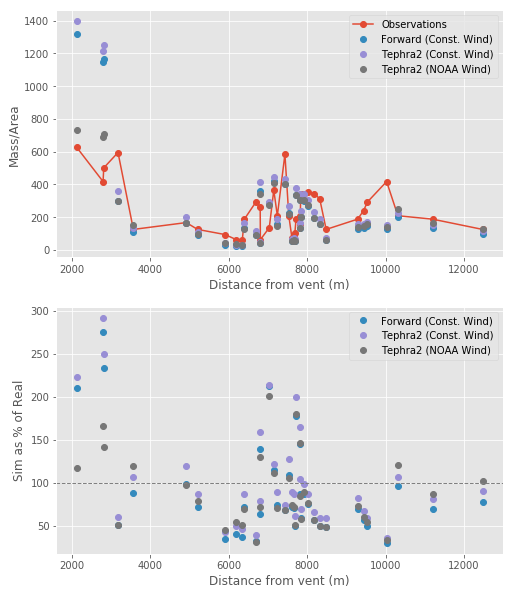

In [11]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values*100, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values*100, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values*100, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Const. Wind Simulation========
a* = -4.91988	b* = -0.60780            	h1* = 1.49994
a = 1.00730	b = 1.54455	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 49
SSE: 2.8166126806927436


,Height,Suspended Mass
0,"4,430.75",5.47429e+09
1,"5,776.5",5.29269e+09
2,"7,122.25",5.09118e+09
3,"8,468",4.87618e+09
4,"9,813.75",4.64894e+09
5,"11,159.5",4.40921e+09
6,"12,505.2",4.15592e+09
7,"13,851",3.88725e+09
8,"15,196.8",3.60059e+09
9,"16,542.5",3.29211e+09


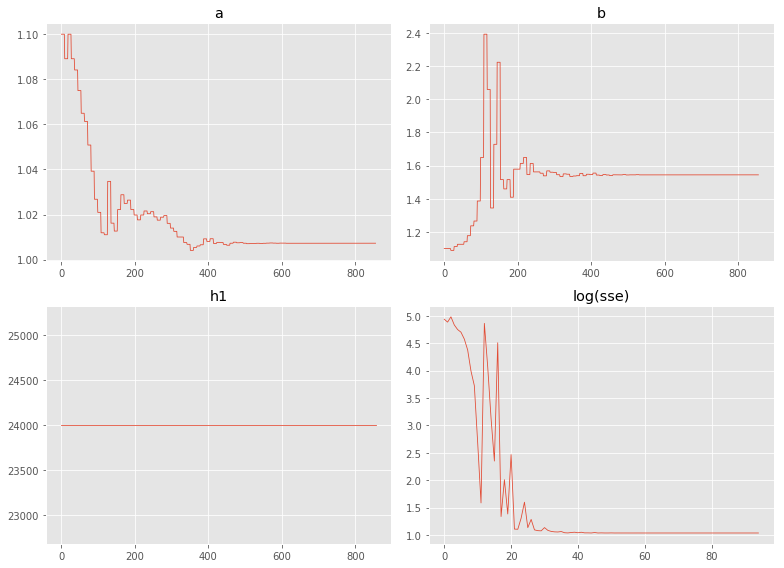

========T2 Const. Wind Simulation========
a* = -2.33182	b* = -0.18031            	h1* = 1.49994
a = 1.09712	b = 1.83501	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 19.941084853868


,Height,Suspended Mass
0,"4,430.75",5.61728e+09
1,"5,776.5",5.66141e+09
2,"7,122.25",5.52339e+09
3,"8,468",5.29915e+09
4,"9,813.75",5.02056e+09
5,"11,159.5",4.70217e+09
6,"12,505.2",4.35162e+09
7,"13,851",3.97309e+09
8,"15,196.8",3.56869e+09
9,"16,542.5",3.139e+09


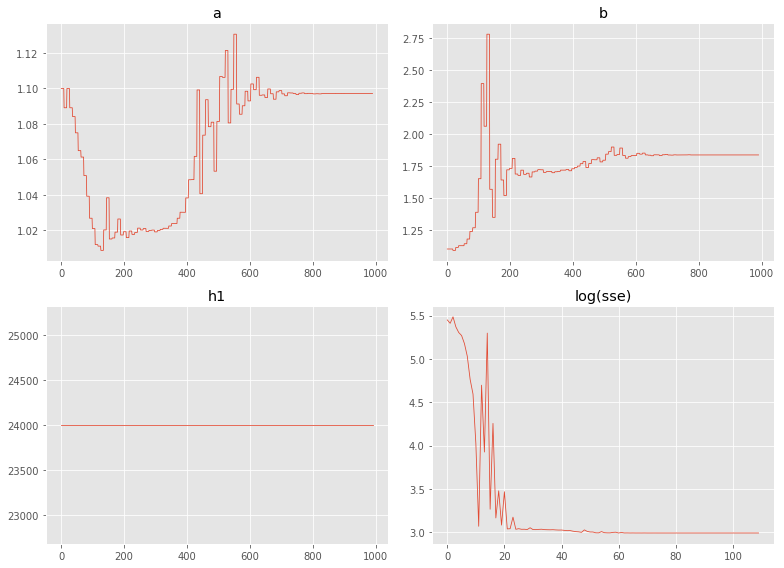

========T2 NOAA Wind Simulation========
a* = -1.68438	b* = -3.20161            	h1* = 1.49994
a = 1.18556	b = 1.04070	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 36
SSE: 307.7407169620315


,Height,Suspended Mass
0,"4,430.75",2.68024e+09
1,"5,776.5",3.0393e+09
2,"7,122.25",3.26657e+09
3,"8,468",3.43406e+09
4,"9,813.75",3.56606e+09
5,"11,159.5",3.67383e+09
6,"12,505.2",3.76344e+09
7,"13,851",3.83836e+09
8,"15,196.8",3.90052e+09
9,"16,542.5",3.95077e+09


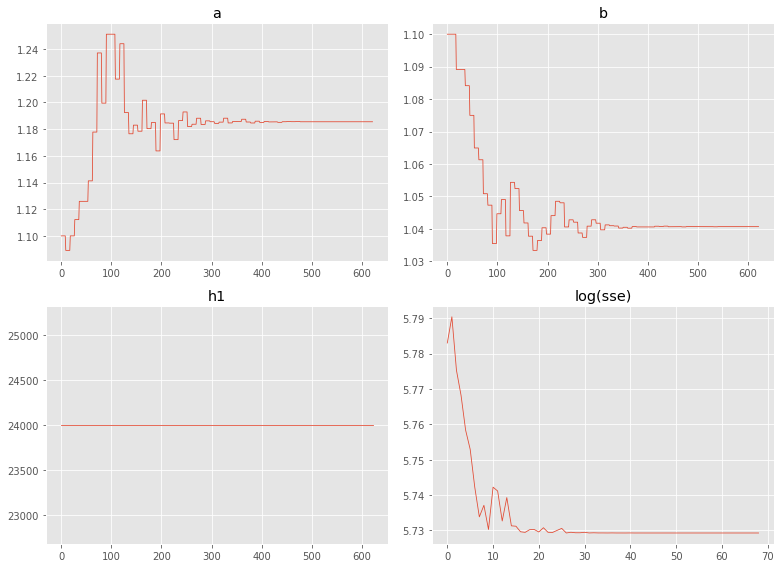

========Observation Data========
a* = -3.83275	b* = 0.50453            	h1* = 1.49994
a = 1.02165	b = 2.65620	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 45
SSE: 2687.4456554214867


,Height,Suspended Mass
0,"4,430.75",8.93963e+09
1,"5,776.5",8.06474e+09
2,"7,122.25",7.1651e+09
3,"8,468",6.28289e+09
4,"9,813.75",5.43338e+09
5,"11,159.5",4.62482e+09
6,"12,505.2",3.86287e+09
7,"13,851",3.15213e+09
8,"15,196.8",2.49684e+09
9,"16,542.5",1.90131e+09


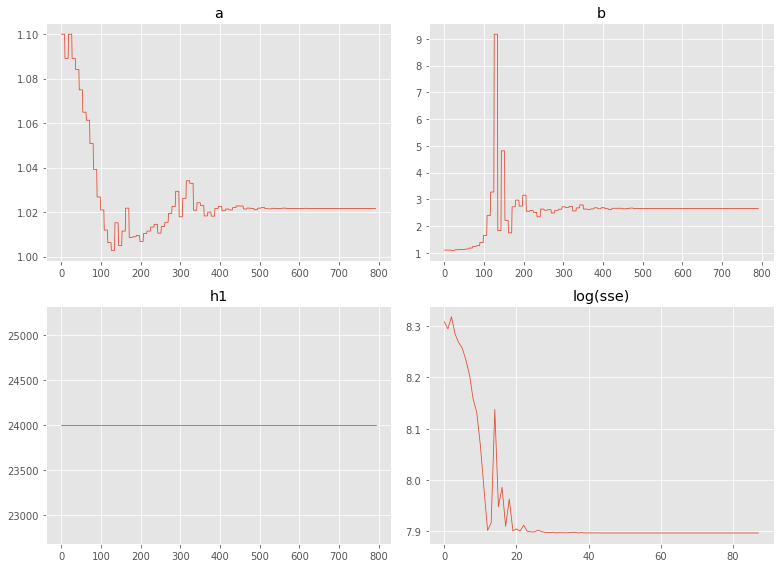

In [12]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : False,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Const. Wind Simulation", "T2 Const. Wind Simulation","T2 NOAA Wind Simulation", "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_plume_inversion(
        df, len(df), 20, 
        config["VENT_ELEVATION"], H, 2500,
        phi_steps, config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, params, sol, sse, trace, _, sse_trace = out
    
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



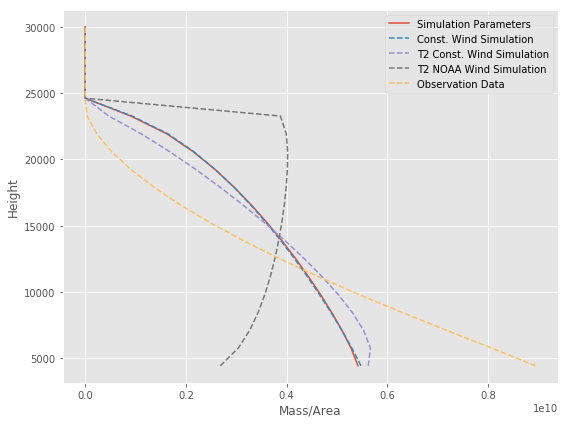

In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()


========Const. Wind Simulation========


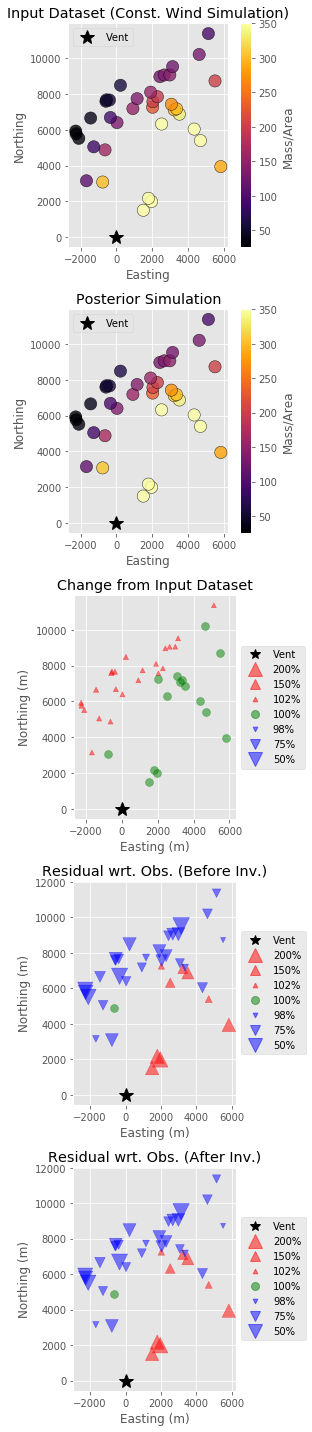

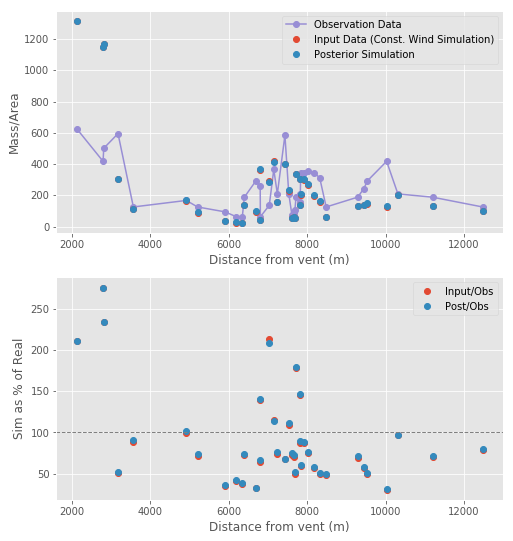

========T2 Const. Wind Simulation========


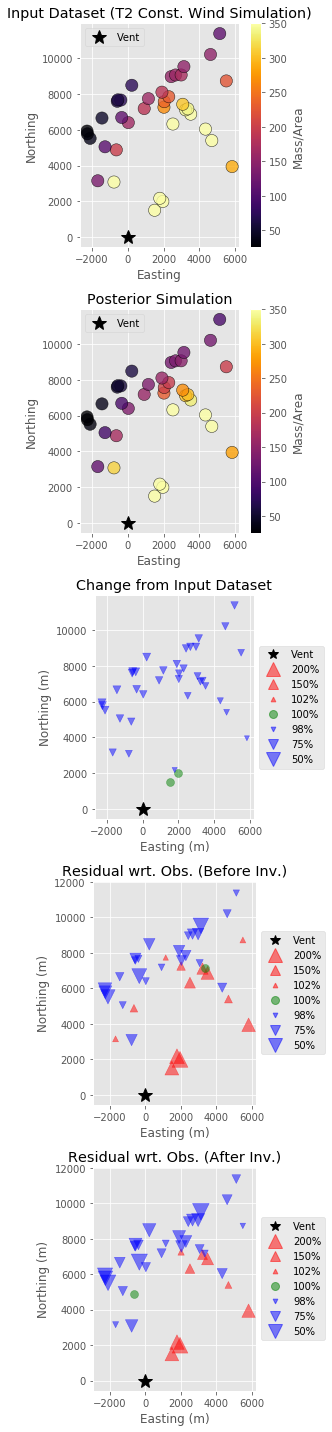

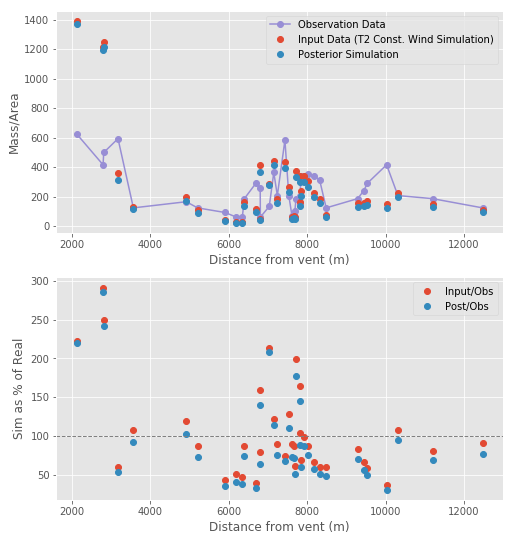

========T2 NOAA Wind Simulation========


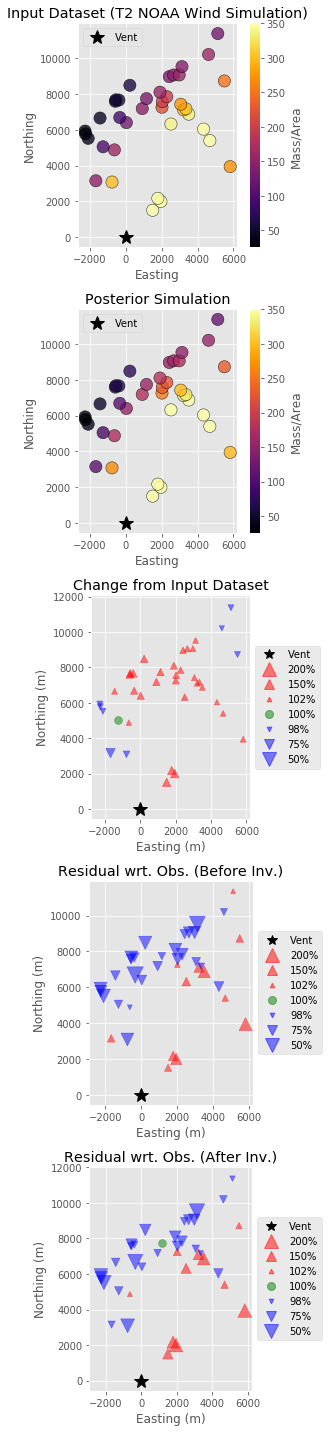

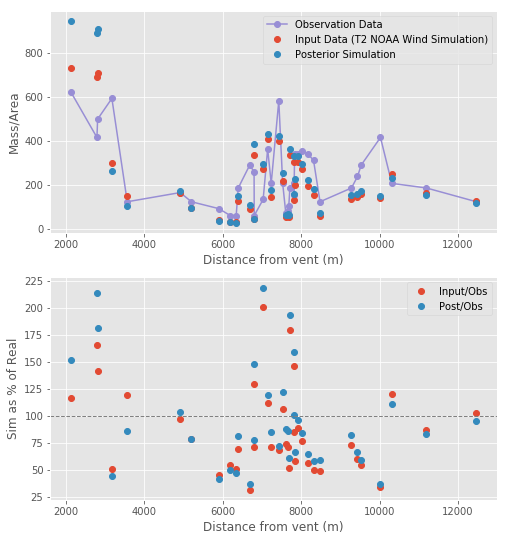

========Observation Data========


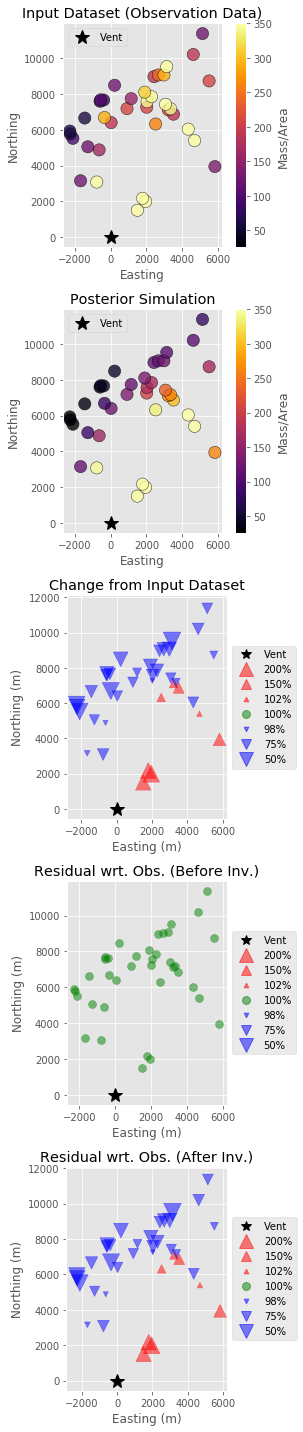

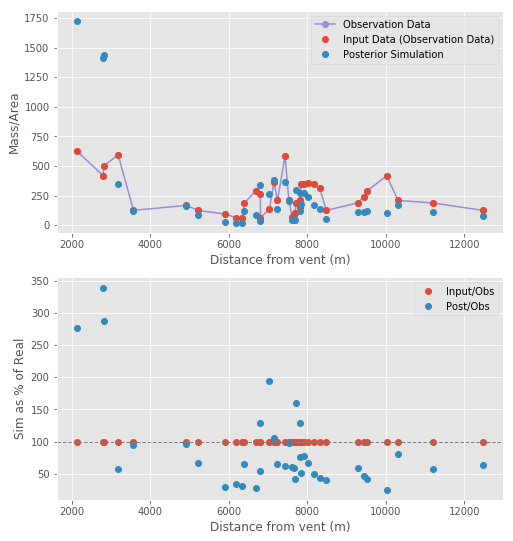

In [14]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values
    
    fig, axs = plt.subplots(5,1, figsize=(
            5, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    bounds = (25, 350)
    vis.plot_sample(in_data, vent=(0,0), log=False,bounds=bounds, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, bounds=bounds,
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_residuals(post_df, vent=(0,0), values="Change", plot_type="size",
                title="Change from Input Dataset", ax=axs[2])
    vis.plot_residuals(in_data, vent=(0,0), values="Residual", plot_type="size",
                title="Residual wrt. Obs. (Before Inv.)", ax=axs[3])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="size",
                title="Residual wrt. Obs. (After Inv.)", ax=axs[4])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values*100, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

========Const. Wind Simulation========
a* = 0.01425	b* = 1.42184	            h1* = 4.93676	u* = 5.91686	v* = 7.89618	            D* = 8.47658	ftt* = 7.86149	TM* = 24.73060
a = 2.01435	b = 5.14473	            h1 = 29785.43612	u = 5.91686	v = 7.89618	            D = 4800.97850	ftt = 2595.38426	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 932
SSE: 42.31973127891901


,Height,Suspended Mass
0,"4,430.75",3.51019e+09
1,"5,776.5",5.65603e+09
2,"7,122.25",6.71887e+09
3,"8,468",6.97969e+09
4,"9,813.75",6.67971e+09
5,"11,159.5",6.01871e+09
6,"12,505.2",5.15725e+09
7,"13,851",4.21988e+09
8,"15,196.8",3.29882e+09
9,"16,542.5",2.45788e+09


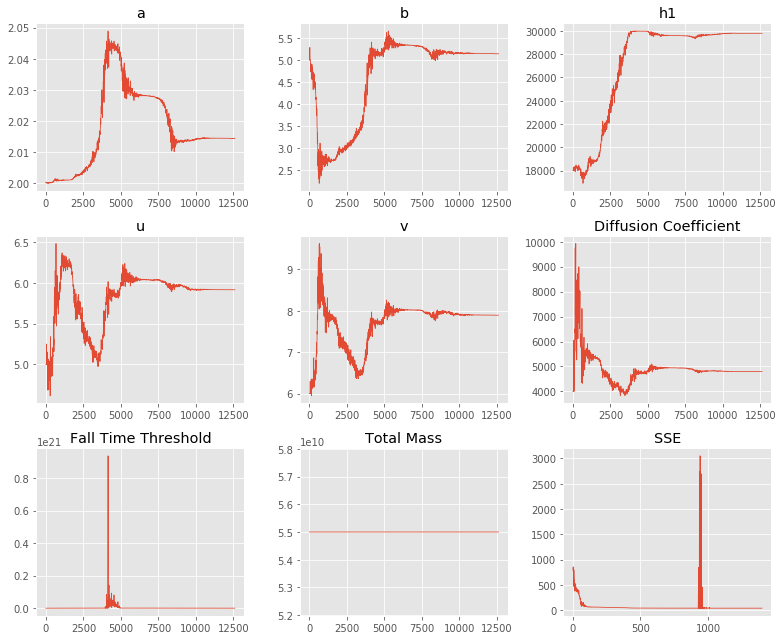

Const. Wind Simulation Run Time: 2.17500 minutes


========T2 Const. Wind Simulation========
a* = 0.03418	b* = 1.52662	            h1* = 3.99935	u* = 5.57908	v* = 8.67867	            D* = 8.43059	ftt* = 7.85414	TM* = 24.73060
a = 2.03477	b = 5.60258	            h1 = 29455.17961	u = 5.57908	v = 8.67867	            D = 4585.18650	ftt = 2576.38978	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 934
SSE: 51.846877573375686


,Height,Suspended Mass
0,"4,430.75",3.98786e+09
1,"5,776.5",6.33498e+09
2,"7,122.25",7.36207e+09
3,"8,468",7.44822e+09
4,"9,813.75",6.91617e+09
5,"11,159.5",6.02459e+09
6,"12,505.2",4.97148e+09
7,"13,851",3.90066e+09
8,"15,196.8",2.90931e+09
9,"16,542.5",2.05576e+09


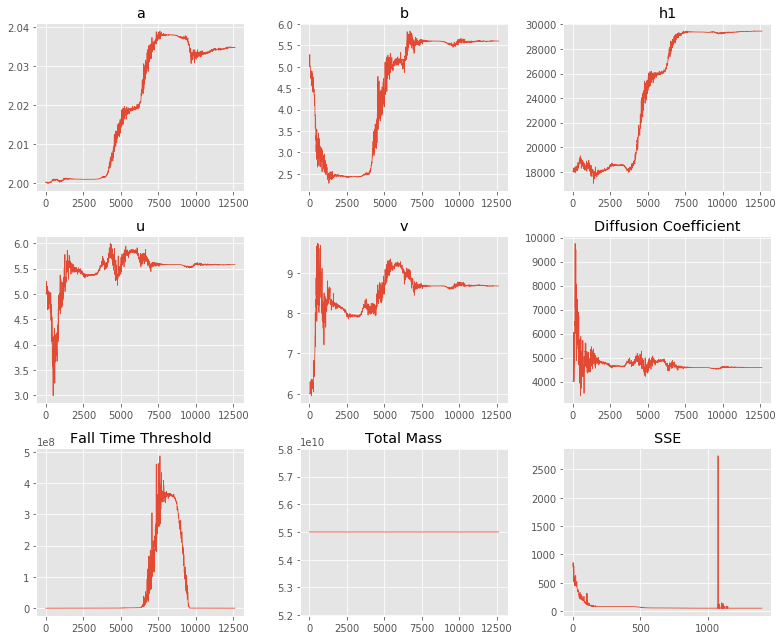

T2 Const. Wind Simulation Run Time: 2.15521 minutes


========T2 NOAA Wind Simulation========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:435: RuntimeWarning: overflow encountered in exp
  return np.exp(p_star)


a* = -2.89256	b* = -0.82503	            h1* = 2.63870	u* = 6.49799	v* = 8.48770	            D* = 8.85413	ftt* = 6156.16867	TM* = 24.73060
a = 1.05543	b = 1.43822	            h1 = 27931.17840	u = 6.49799	v = 8.48770	            D = 7003.27128	ftt = inf	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 968
SSE: 144.73222696891096


,Height,Suspended Mass
0,"4,430.75",3.92443e+09
1,"5,776.5",3.97412e+09
2,"7,122.25",3.95436e+09
3,"8,468",3.90191e+09
4,"9,813.75",3.82837e+09
5,"11,159.5",3.73864e+09
6,"12,505.2",3.63501e+09
7,"13,851",3.51842e+09
8,"15,196.8",3.38895e+09
9,"16,542.5",3.24597e+09


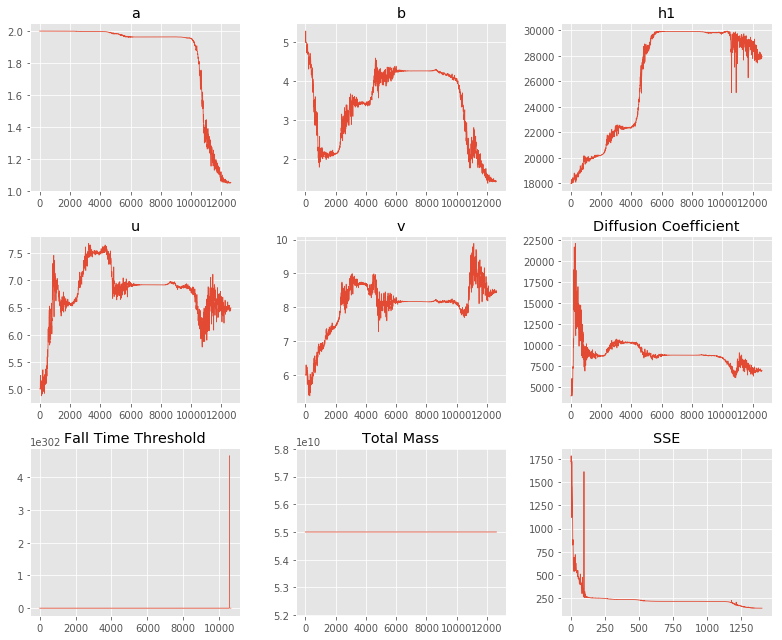

T2 NOAA Wind Simulation Run Time: 2.12266 minutes


========Observation Data========
a* = 0.01346	b* = 0.94451	            h1* = 4.17484	u* = 2.21075	v* = 5.60028	            D* = 9.06763	ftt* = 8.68672	TM* = 24.73060
a = 2.01355	b = 3.57156	            h1 = 29542.19829	u = 2.21075	v = 5.60028	            D = 8670.03034	ftt = 5923.70942	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 878
SSE: 787.7985256124052


,Height,Suspended Mass
0,"4,430.75",1.98981e+09
1,"5,776.5",3.48662e+09
2,"7,122.25",4.52668e+09
3,"8,468",5.16748e+09
4,"9,813.75",5.46771e+09
5,"11,159.5",5.48472e+09
6,"12,505.2",5.27353e+09
7,"13,851",4.88633e+09
8,"15,196.8",4.37207e+09
9,"16,542.5",3.77616e+09


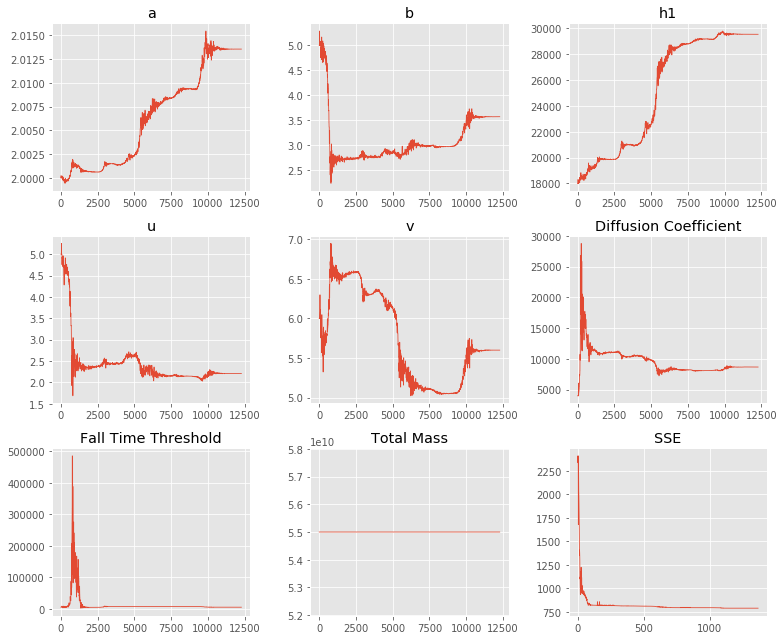

Observation Data Run Time: 2.13802 minutes


Total Run Time: 8.59089 minutes


In [15]:
priors_vals = {
    "a": 2,
    "b": 5,
    "h1": 18000,
    "u": 5,
    "v": 6,
    "D": 4000,
    "ftt": 6000,
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": True,
    "M": False
}

H = 30000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Const. Wind Simulation", 
         "T2 Const. Wind Simulation",
         "T2 NOAA Wind Simulation", 
         "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, phi_steps,
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

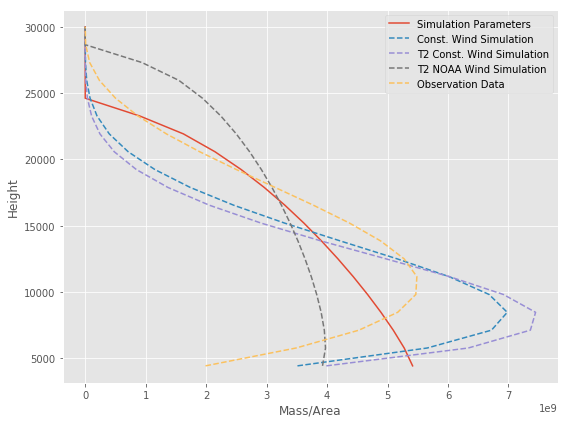

,Dataset,a,b,h1,u,v,D,ftt,M
0,Const. Wind Simulation,2.01435,5.14473,"29,785.4",5.91686,7.89618,"4,800.98","2,595.38",5.5e+10
1,T2 Const. Wind Simulation,2.03477,5.60258,"29,455.2",5.57908,8.67867,"4,585.19","2,576.39",5.5e+10
2,T2 NOAA Wind Simulation,1.05543,1.43822,"27,931.2",6.49799,8.4877,"7,003.27",inf,5.5e+10
3,Observation Data,2.01355,3.57156,"29,542.2",2.21075,5.60028,"8,670.03","5,923.71",5.5e+10


In [16]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()
params_df = pd.DataFrame(params_list)
params_df["Dataset"] = names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========Const. Wind Simulation========


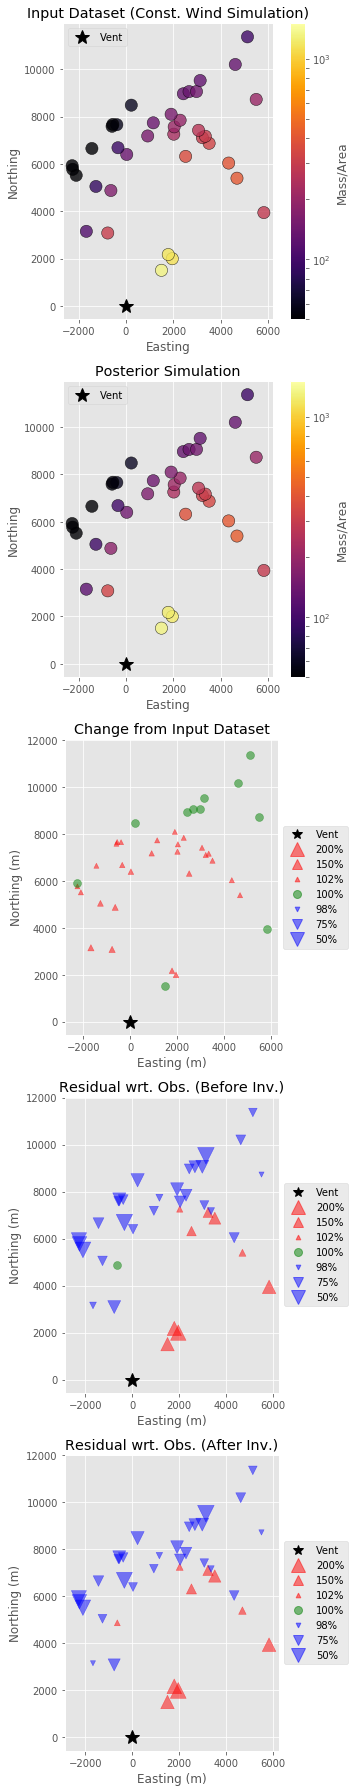

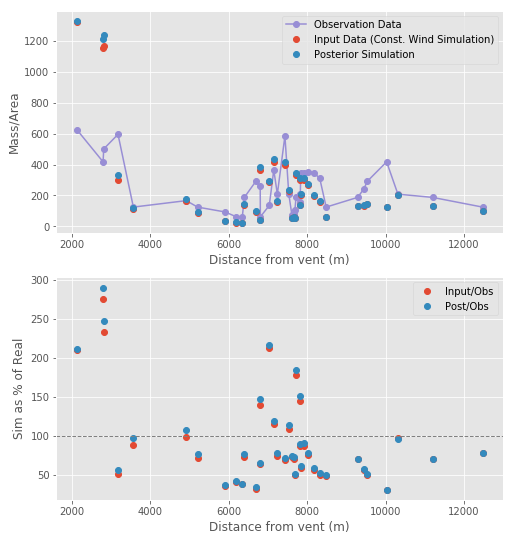

========T2 Const. Wind Simulation========


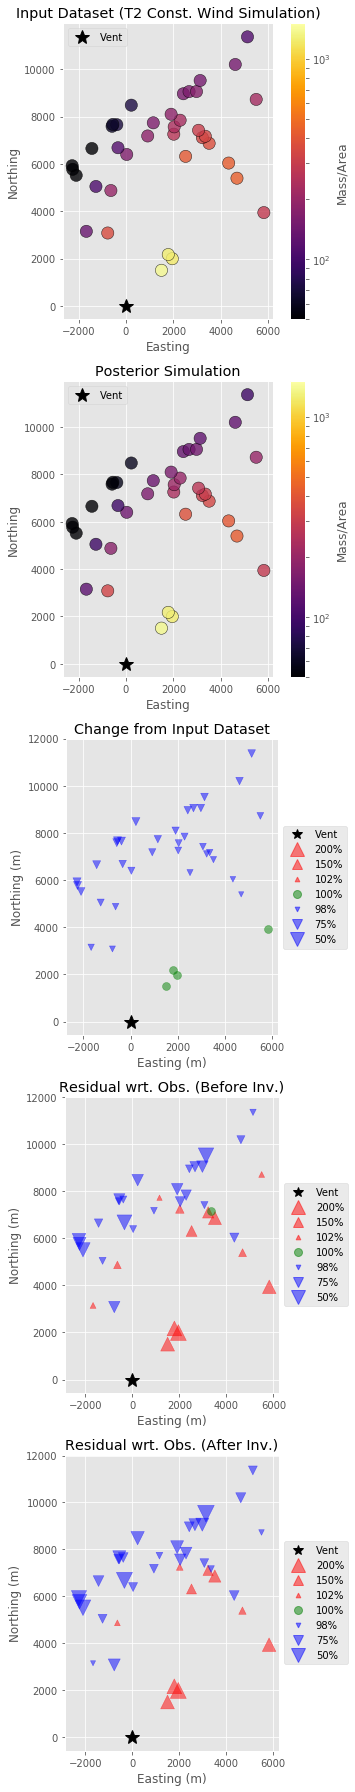

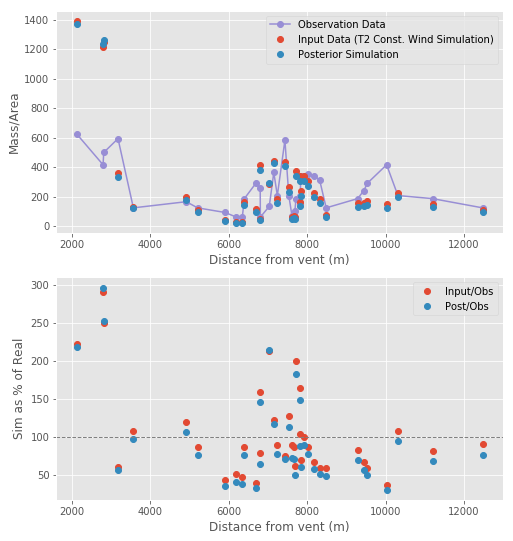

========T2 NOAA Wind Simulation========


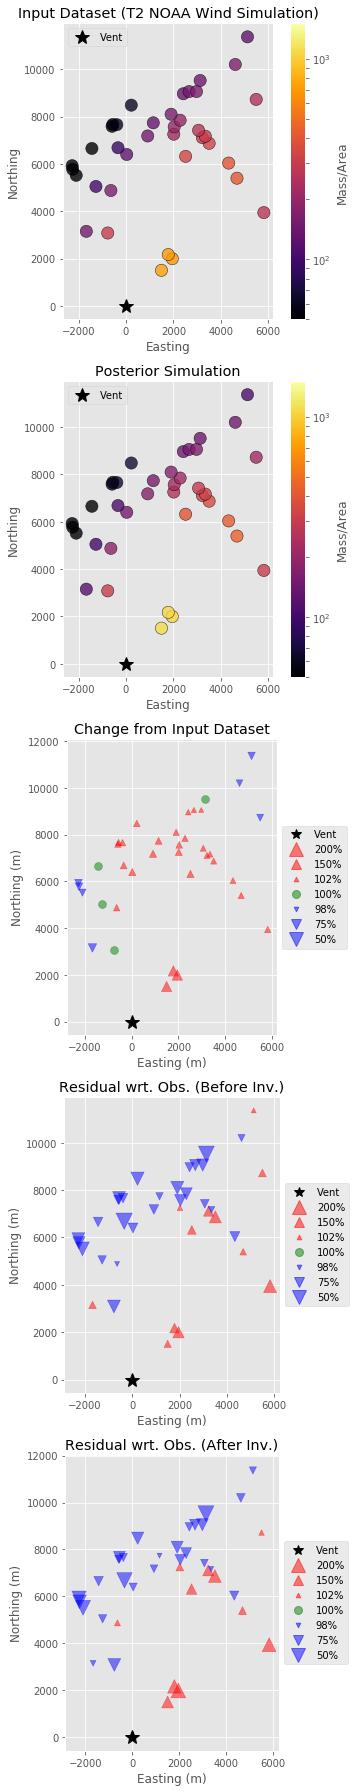

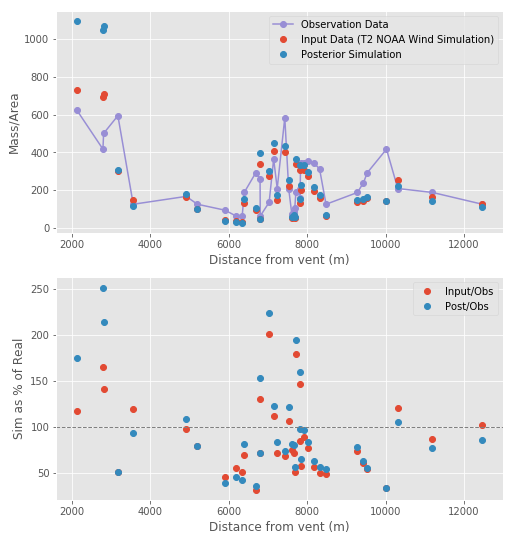

========Observation Data========


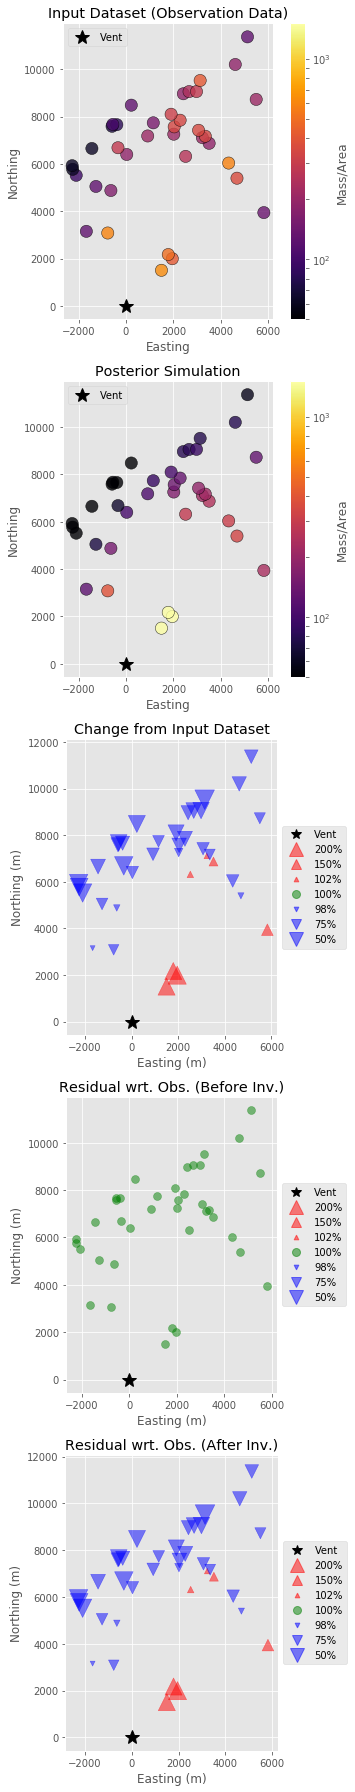

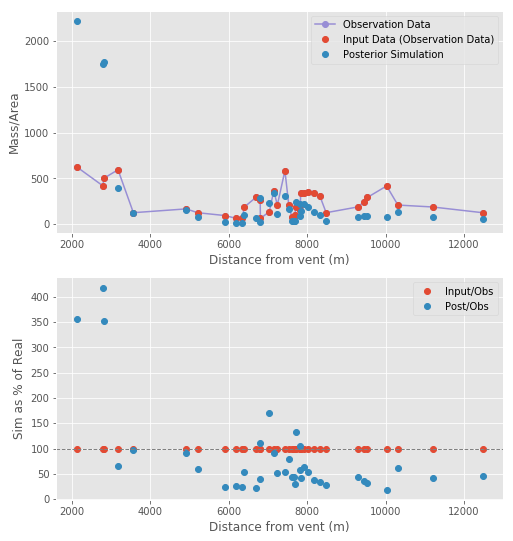

In [18]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values
    
    fig, axs = plt.subplots(5,1, figsize=(
            6, 25), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    bounds=(50, 1500)
    vis.plot_sample(in_data, vent=(0,0), log=True,bounds=bounds, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=True, bounds=bounds,
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_residuals(post_df, vent=(0,0), values="Change", plot_type="size",
                title="Change from Input Dataset", ax=axs[2])
    vis.plot_residuals(in_data, vent=(0,0), values="Residual", plot_type="size",
                title="Residual wrt. Obs. (Before Inv.)", ax=axs[3])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="size",
                title="Residual wrt. Obs. (After Inv.)", ax=axs[4])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values*100, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   